In [1]:
"""Propagating 2D dynamics on the muller potential using OpenMM.
Currently, we just put a harmonic restraint on the z coordinate,
since OpenMM needs to work in 3D. This isn't really a big deal, except
that it affects the meaning of the temperature and kinetic energy. So
take the meaning of those numbers with a grain of salt.
"""
from openmm.unit import kelvin, picosecond, femtosecond, nanometer, dalton
import openmm as mm

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

from energy_landscape import MullerForce, ModifiedMullerForce, landscape
from muller_utils import (ObsBoundReInit, random_init_point, target_init_point,
                          find_region_change, deepest_well_escape_frame)

import os, tqdm, pickle, yaml
from datetime import datetime

# Parameter Set-up

In [2]:
# random start or target start
start_mode = 'target'

In [3]:
# Get the current time
current_time = datetime.now()
formatted_time = current_time.strftime('%y%m%d_%H%M')
directory = f"results/muller/base/{start_mode}_{formatted_time}"
if not os.path.exists(directory):
    os.makedirs(directory)

In [21]:
# Observation Guided Navigation parameters
random_seed = 1
np.random.seed(random_seed)
total_step = 100000       # total number of steps

# Brownian simulation parameters
## each particle is totally independent, propagating under the same potential
nParticles = 1  
temp_non_dimensional = 750
mass_non_dimensional = 1.0
friction_non_dimensional = 100
timestep_non_dimensional = 10.0
step = 100
temperature = temp_non_dimensional * kelvin
mass = mass_non_dimensional * dalton
friction = friction_non_dimensional / picosecond
timestep = timestep_non_dimensional * femtosecond


# set up x and y limits for the plot
x_limits = (-3.4, 1.7)
y_limits = (-1.4, 3.4)

# define initial point
if start_mode == 'random':
    init = random_init_point(x_limits, y_limits) # np.array([-0.9, 1.4, np.random.uniform(0, 1)])
elif start_mode == 'target':
    init = target_init_point(-0.5, 1.4)

In [22]:
# Define all other parameters and include them in a dictionary
parameters = {
    'start_mode': start_mode,
    'total_step': total_step,
    'random_seed': random_seed,
    'nParticles': nParticles,
    'mass': mass_non_dimensional,
    'temperature': temp_non_dimensional,
    'friction': friction_non_dimensional,
    'timestep': timestep_non_dimensional,
    'step': step,
}


# Serialize and save as a YAML file
with open(os.path.join(directory, 'param.yaml'), 'w') as file:
    yaml.dump(parameters, file)

# Run simulation

In [23]:
# Brownian simulation set-up
system = mm.System()
pes = landscape('Muller')

for i in range(nParticles):
    system.addParticle(mass)
    pes.addParticle(i, [])
system.addForce(pes)

integrator = mm.LangevinIntegrator(temperature, friction, timestep)
context = mm.Context(system, integrator)

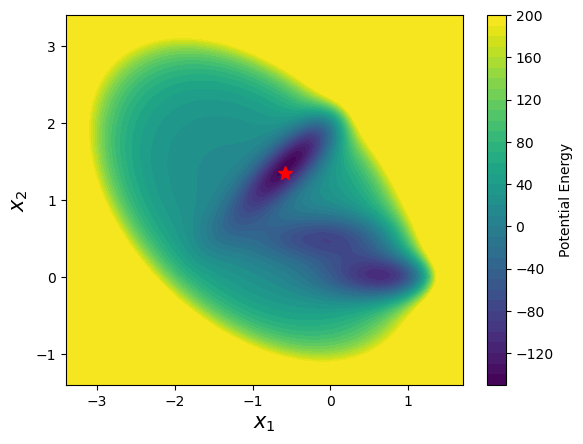

In [24]:
ft = 15
e = 0.2
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)

plt.plot(init[:, 0], init[:, 1], '*', color='r', markersize=10)
plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.xlim(x_limits[0], x_limits[1])
plt.ylim(y_limits[0], y_limits[1])
plt.show()

step 0: | cent: [  -0.58    1.36 -141.42]
step 1000: | cent: [  -0.56    1.44 -139.39]
step 2000: | cent: [  -0.57    1.43 -139.35]
step 3000: | cent: [  -0.57    1.43 -139.48]
step 4000: | cent: [  -0.57    1.43 -139.38]
step 5000: | cent: [  -0.57    1.43 -139.38]
step 6000: | cent: [  -0.57    1.43 -139.63]
step 7000: | cent: [  -0.57    1.43 -138.92]
step 8000: | cent: [  -0.57    1.43 -139.18]
step 9000: | cent: [  -0.56    1.43 -139.18]
step 10000: | cent: [  -0.56    1.43 -139.12]
step 11000: | cent: [  -0.57    1.43 -139.28]
step 12000: | cent: [  -0.56    1.44 -139.23]
step 13000: | cent: [  -0.56    1.44 -139.41]
step 14000: | cent: [  -0.56    1.44 -139.48]
step 15000: | cent: [  -0.57    1.44 -139.35]
step 16000: | cent: [  -0.57    1.43 -139.2 ]
step 17000: | cent: [  -0.56    1.43 -139.29]
step 18000: | cent: [  -0.57    1.43 -139.42]
step 19000: | cent: [  -0.56    1.44 -139.59]
step 20000: | cent: [  -0.56    1.43 -139.08]
step 21000: | cent: [  -0.57    1.43 -139.05]
s

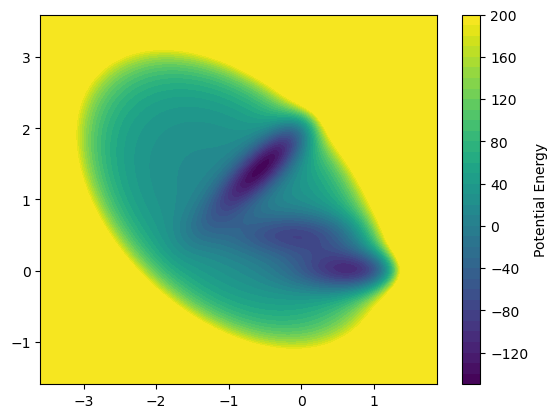

In [25]:
# traj_all_save = []
startingPositions = init
interval = int(total_step/10) #1000 
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)


context.setPositions(startingPositions)
context.setVelocitiesToTemperature(temperature)

traj = np.zeros((total_step, 3))
for i in range(total_step):
    # Assuming context, pes, and integrator are predefined and properly set up
    x = context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(nanometer)   
    p = x[0]
    E = pes.potential(x=p[0], y=p[1])  # Ensure pes.potential() handles inputs safely and returns a sensible value
    
    traj[i] = np.array([p[0], p[1], E])
    integrator.step(step)

    # Ensure we have a valid range for calculating the mean
    if i > 0:  # Ensure there's at least one step to average
        start_index = max(0, i-interval)
        # Use np.nanmean to safely calculate the mean, ignoring NaN values
        cent = np.nanmean(traj[start_index:i], axis=0)
        if (i % interval == 0): 
            print(f'step {i}: | cent: {np.round(cent.flatten(),2)}')
    else:
        # For the very first step, just print the current position
        print(f'step {i}: | cent: {np.round(traj[i].flatten(),2)}')

In [26]:
result = {
    'init': init,
    'traj_all_save': traj
}

# save the result into pickle
with open(os.path.join(directory, 'result.pkl'), 'wb') as file:
    pickle.dump(result, file)

# All data points

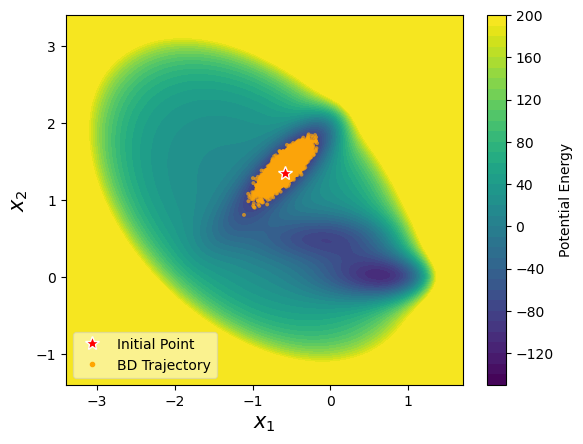

In [27]:
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)

colors = cm.inferno(np.linspace(0.8, 0.2))
plt.plot(init[:, 0], init[:, 1], 
         '*', markeredgecolor='white', color='r', 
         markersize=10, label='Initial Point')

plt.scatter(traj[:,0], traj[:,1], 
            edgecolor='none', 
            s=8, color=colors[0], 
            alpha=0.7) #, label=f'Data Point')

plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.xlim(x_limits[0], x_limits[1])
plt.ylim(y_limits[0], y_limits[1])
plt.plot([], [], '.', c='orange', label='BD Trajectory') 

plt.legend(fontsize=ft-5, loc='lower left', framealpha=0.5)
plt.savefig(os.path.join(directory,'all_points.png'), bbox_inches='tight', facecolor='w')
plt.show()

# Potential Curve

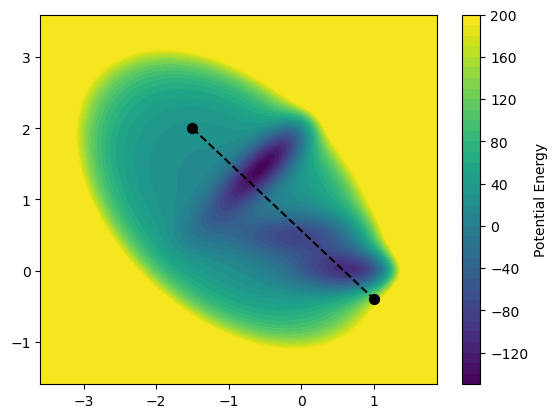

In [66]:
# plot trajectories
pes.plot(ax=plt.gca(), 
         minx=x_limits[0]-e, maxx=x_limits[1]+e, 
         miny=y_limits[0]-e, maxy=y_limits[1]+e)

start_point = (-1.5, 2.0)
end_point = (1.0, -0.4)
plt.scatter(start_point[0], start_point[1], marker='o', s=50, color='k')
plt.scatter(end_point[0], end_point[1], marker='o', s=50, color='k')
plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'k--')
plt.savefig(os.path.join(directory,'cutting_plane.png'), bbox_inches='tight', facecolor='w')

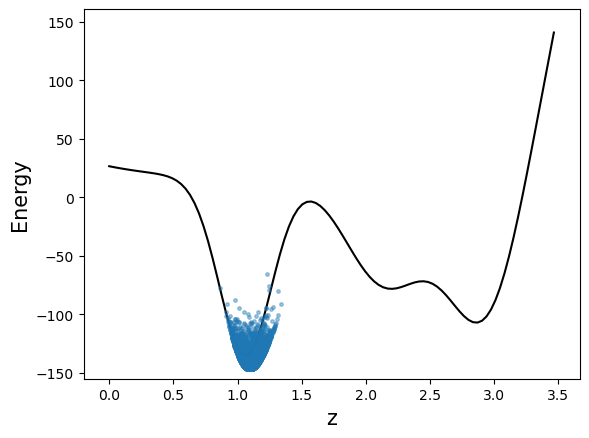

In [68]:
# Determine z values for the cutting plane
traj_all = traj
x_all = traj_all[:, 0] - start_point[0]
y_all = traj_all[:, 1] - start_point[1]
E_all = traj_all[:, 2]
z_all = np.sqrt(x_all**2 + y_all**2)

# Define the number of points you want on the diagonal line
num_points = 100  # You can adjust this number as needed

# Calculate the (x, y) coordinates along the diagonal line
x_values = np.linspace(start_point[0], end_point[0], num_points)
y_values = np.linspace(start_point[1], end_point[1], num_points)
z_values = np.sqrt((x_values-start_point[0])**2+(y_values-start_point[1])**2)
# Calculate energy values for the (x, y) coordinates
muller_force = MullerForce()
E_values = muller_force.potential(x_values, y_values)


# Plot the energy curve
plt.plot(z_values, E_values, 'k-')
plt.plot(z_all, E_all, '.', markersize=5, alpha=0.4)


plt.xlim(min(z_values)-0.2, max(z_values)+0.2)
plt.ylim(min(E_values)-20, max(E_values)+20)
# plt.legend(fontsize=ft-5, loc='best')
plt.xlabel('z', fontsize=ft)
plt.ylabel('Energy', fontsize=ft)
plt.savefig(os.path.join(directory,'energy_curve.png'), bbox_inches='tight', facecolor='w')
plt.show()

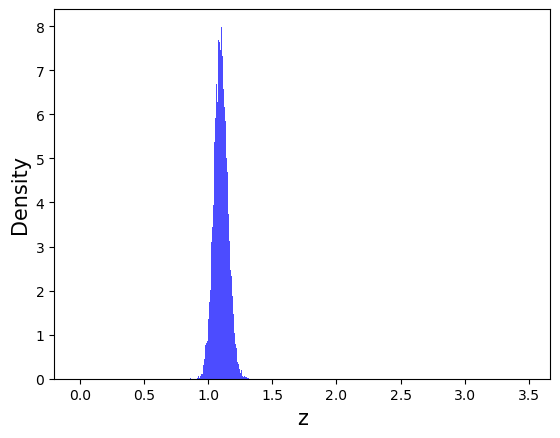

In [69]:
# Plot the distribution
plt.hist(z_all, bins=100, density=True, color='b', alpha=0.7)
plt.xlabel('z', fontsize=ft)
plt.ylabel('Density', fontsize=ft)
plt.xlim(min(z_values)-0.2, max(z_values)+0.2)
# plt.title('Distribution of Distance from Start Point')
# plt.legend(fontsize=ft-5, loc='best')
plt.savefig(os.path.join(directory,'histogram.png'), bbox_inches='tight', facecolor='w')

plt.show()

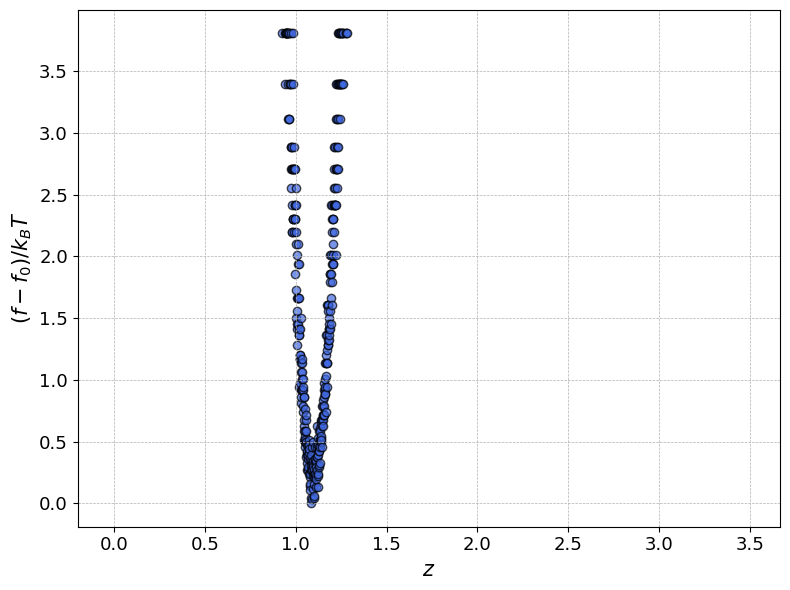

In [70]:
counts, bins = np.histogram(z_all, bins=500)
anchors = (bins[1:] + bins[:-1]) / 2

probs = counts / np.sum(counts)

anchors = anchors[np.where(probs > 0.0001)]
probs = probs[np.where(probs > 0.0001)]

f = -np.log(probs)
fn = f - np.min(f)

# Making the plot more beautiful
plt.figure(figsize=(8, 6))  # Set figure size


# Visualize the results with improved aesthetics
plt.scatter(anchors, fn, color='royalblue', alpha=0.7, edgecolor='black')

plt.xlabel("$z$", fontsize=ft)
plt.ylabel(r"$(f - f_0) / k_B T$", fontsize=ft)
plt.xticks(fontsize=ft-2)
plt.yticks(fontsize=ft-2)
plt.xlim(min(z_values)-0.2, max(z_values)+0.2)
# plt.title('Reconstructed Energy Landscape', fontsize=16)
# plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig(os.path.join(directory,'recon_energy_curve.png'), bbox_inches='tight', facecolor='w')
plt.show()